## Bug Classification Using NLP - Machine Learning

### Importing packages

In [105]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import spacy
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Data preprocessing

In [91]:
# Loading data
raw_data = pd.read_csv('Firefox.csv')
raw_data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1582360,defect,Firefox 68.1.0 ESR language change problem,Firefox,Enterprise Policies,nobody,UNCONFIRMED,---,5/18/2020 8:09
1,1603445,defect,In Options>Applications>PDF - I change the PDF...,Firefox,PDF Viewer,nobody,UNCONFIRMED,---,9/6/2020 11:20
2,1606620,task,right click context menu displaying in first s...,Firefox,Menus,nobody,UNCONFIRMED,---,12/22/2020 7:09
3,1653320,defect,Global sharing indicator blocks access to menu...,Firefox,Site Permissions,mconley,UNCONFIRMED,---,8/26/2020 14:32
4,1355978,defect,show tab favicons immediately,Firefox,Tabbed Browser,nobody,UNCONFIRMED,---,1/22/2019 12:08


### Preliminary Analysis

In [92]:
raw_data.describe(include = 'all')

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
count,1.000000e+04,10000,10000,10000,10000,10000,10000,10000,10000
unique,NaN,3,9999,1,48,112,2,1,8661
top,NaN,defect,Firefox does not close properly,Firefox,General,nobody,NEW,---,6/28/2019 14:29
freq,NaN,6888,2,10000,1841,9744,5652,10000,206
mean,1.199937e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.154172e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.148200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.544160e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.373375e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.544914e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Data info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Bug ID      10000 non-null  int64 
 1   Type        10000 non-null  object
 2   Summary     10000 non-null  object
 3   Product     10000 non-null  object
 4   Component   10000 non-null  object
 5   Assignee    10000 non-null  object
 6   Status      10000 non-null  object
 7   Resolution  10000 non-null  object
 8   Updated     10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.2+ KB


In [94]:
# checking for Null values
raw_data.isnull().sum()

Bug ID        0
Type          0
Summary       0
Product       0
Component     0
Assignee      0
Status        0
Resolution    0
Updated       0
dtype: int64

In [95]:
# Bug Type categories with count
raw_data['Type'].value_counts()

defect         6888
enhancement    2656
task            456
Name: Type, dtype: int64

In [96]:
# Components with count
raw_data['Component'].value_counts()

General                                 1841
Tabbed Browser                           814
Preferences                              603
New Tab Page                             504
Address Bar                              495
Toolbars and Customization               422
Session Restore                          411
Bookmarks & History                      404
Theme                                    384
File Handling                            344
PDF Viewer                               336
Sync                                     328
Menus                                    321
Security                                 301
Search                                   289
Keyboard Navigation                      198
Downloads Panel                          196
Shell Integration                        159
Messaging System                         144
Installer                                135
Site Permissions                         134
Private Browsing                         122
WebPayment

### Natural Language Processing

In [97]:
# Loading Spacy
nlp = spacy.load('en_core_web_lg')

In [98]:
# Apply NLP to all summary column
raw_data.Summary = raw_data.Summary.apply(lambda summary: nlp(summary))

# Display data
raw_data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1582360,defect,"(Firefox, 68.1.0, ESR, language, change, problem)",Firefox,Enterprise Policies,nobody,UNCONFIRMED,---,5/18/2020 8:09
1,1603445,defect,"(In, Options, >, Applications, >, PDF, -, I, c...",Firefox,PDF Viewer,nobody,UNCONFIRMED,---,9/6/2020 11:20
2,1606620,task,"(right, click, context, menu, displaying, in, ...",Firefox,Menus,nobody,UNCONFIRMED,---,12/22/2020 7:09
3,1653320,defect,"(Global, sharing, indicator, blocks, access, t...",Firefox,Site Permissions,mconley,UNCONFIRMED,---,8/26/2020 14:32
4,1355978,defect,"(show, tab, favicons, immediately)",Firefox,Tabbed Browser,nobody,UNCONFIRMED,---,1/22/2019 12:08


In [159]:
# Stop words of Spacy Library
stop_words = nlp.Defaults.stop_words

# Copy the data
data = raw_data.copy()

# Removing punctuation (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~)
# Removing stop words (a , an, the, in, on etc)
# Getting the base words through lematization

data.Summary = raw_data.Summary.apply(lambda doc: [token.lemma_ for token in doc
                                                   if (token.text not in punctuation 
                                                       and token.text.lower() not in stop_words)])
# Display data
data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1582360,defect,"[Firefox, 68.1.0, ESR, language, change, problem]",Firefox,Enterprise Policies,nobody,UNCONFIRMED,---,5/18/2020 8:09
1,1603445,defect,"[option, Applications, pdf, change, pdf, use, ...",Firefox,PDF Viewer,nobody,UNCONFIRMED,---,9/6/2020 11:20
2,1606620,task,"[right, click, context, menu, display, screen,...",Firefox,Menus,nobody,UNCONFIRMED,---,12/22/2020 7:09
3,1653320,defect,"[global, sharing, indicator, block, access, me...",Firefox,Site Permissions,mconley,UNCONFIRMED,---,8/26/2020 14:32
4,1355978,defect,"[tab, favicon, immediately]",Firefox,Tabbed Browser,nobody,UNCONFIRMED,---,1/22/2019 12:08


In [100]:
# Joining the tokens
data.Summary = data.Summary.apply(lambda x: " ".join(x))

# Display data with joined tokens
data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1582360,defect,Firefox 68.1.0 ESR language change problem,Firefox,Enterprise Policies,nobody,UNCONFIRMED,---,5/18/2020 8:09
1,1603445,defect,option Applications pdf change pdf use pdf vie...,Firefox,PDF Viewer,nobody,UNCONFIRMED,---,9/6/2020 11:20
2,1606620,task,right click context menu display screen window...,Firefox,Menus,nobody,UNCONFIRMED,---,12/22/2020 7:09
3,1653320,defect,global sharing indicator block access menu macos,Firefox,Site Permissions,mconley,UNCONFIRMED,---,8/26/2020 14:32
4,1355978,defect,tab favicon immediately,Firefox,Tabbed Browser,nobody,UNCONFIRMED,---,1/22/2019 12:08


## Classification on the basis of Type 

### Spliting the data into train and test set:

In [145]:
# Input features
X = data['Summary']

# target
y = data['Type']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

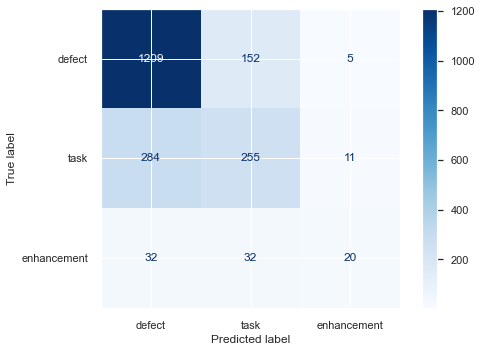

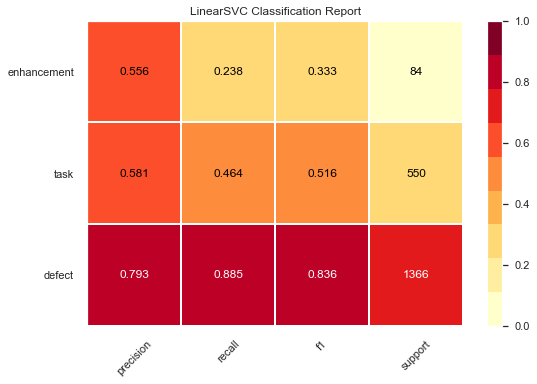

Accuracy:  0.742


In [146]:
# pipeline with Linear SVC
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  LinearSVC())])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
metrics.plot_confusion_matrix(bug_clf, X_test, y_test,
                                 display_labels=data['Type'].unique().tolist(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)

plt.show()

# Print a classification report
visualizer = classification_report(
    bug_clf, X_train, y_train, X_test, y_test, cmap='YlOrRd', classes=data['Type'].unique().tolist(), support=True
)


# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

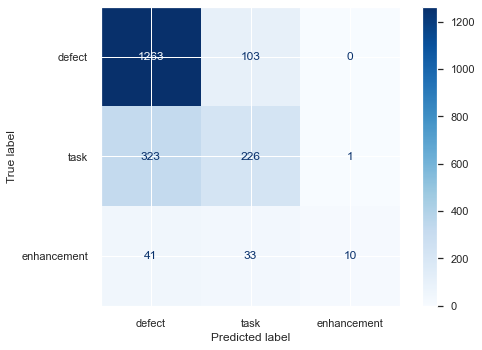

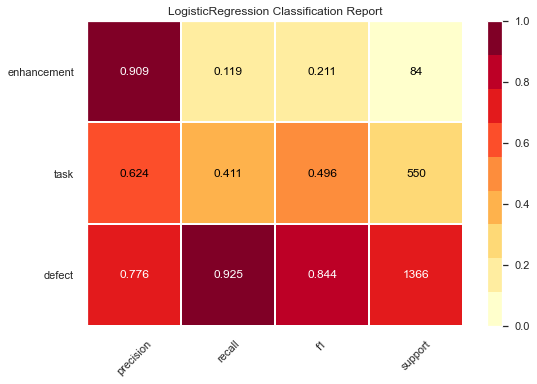

Accuracy:  0.7495


In [118]:
# pipeline with LogisticRegression
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  LogisticRegression(solver='lbfgs', max_iter=1000))])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
metrics.plot_confusion_matrix(bug_clf, X_test, y_test,
                                 display_labels=data['Type'].unique().tolist(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)

plt.show()

# Print a classification report
visualizer = classification_report(
    bug_clf, X_train, y_train, X_test, y_test, cmap='YlOrRd', classes=data['Type'].unique().tolist(), support=True
)


# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

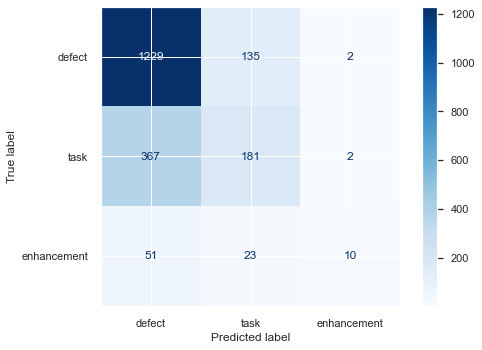

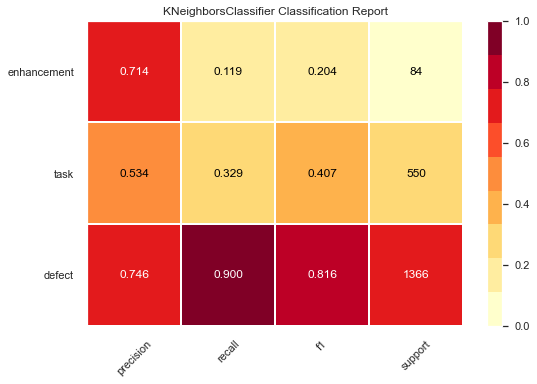

Accuracy:  0.71


In [147]:
# pipeline with KNeighborsClassifier
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  KNeighborsClassifier())])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
metrics.plot_confusion_matrix(bug_clf, X_test, y_test,
                                 display_labels=data['Type'].unique().tolist(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)

plt.show()

# Print a classification report
visualizer = classification_report(
    bug_clf, X_train, y_train, X_test, y_test, cmap='YlOrRd', classes=data['Type'].unique().tolist(), support=True
)

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

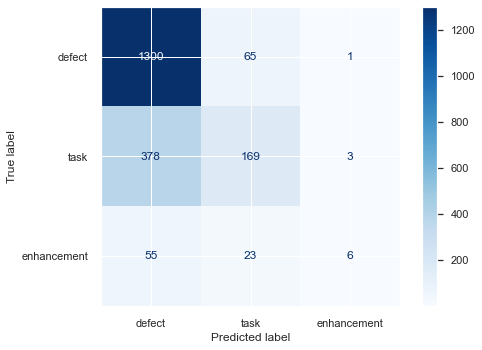

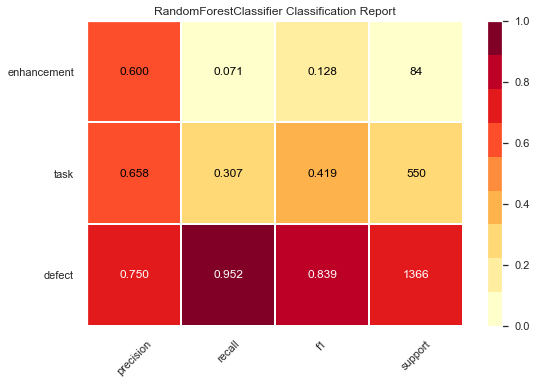

Accuracy:  0.7375


In [120]:
# pipeline with RandomForestClassifier
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  RandomForestClassifier(max_depth=120, random_state=42))])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
metrics.plot_confusion_matrix(bug_clf, X_test, y_test,
                                 display_labels=data['Type'].unique().tolist(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)

plt.show()

# Print a classification report
visualizer = classification_report(
    bug_clf, X_train, y_train, X_test, y_test, cmap='YlOrRd', classes=data['Type'].unique().tolist(), support=True
)

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

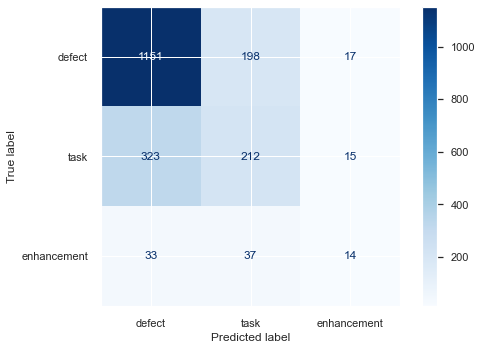

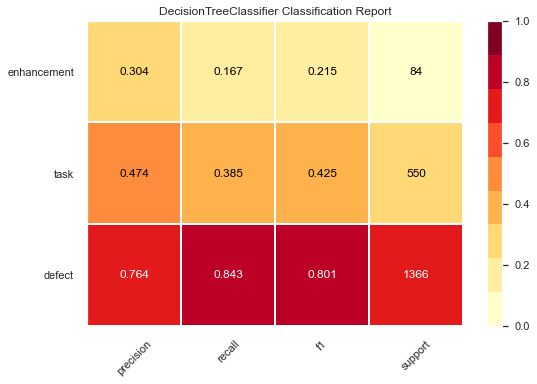

Accuracy:  0.6885


In [148]:
# pipeline with DecisionTreeClassifier
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  DecisionTreeClassifier(max_depth=100, random_state=42))])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
metrics.plot_confusion_matrix(bug_clf, X_test, y_test,
                                 display_labels=data['Type'].unique().tolist(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)

plt.show()

# Print a classification report
visualizer = classification_report(
    bug_clf, X_train, y_train, X_test, y_test, cmap='YlOrRd', classes=data['Type'].unique().tolist(), support=True
)

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

## Classfication on the basis of components

In [149]:
# Input features
X = data['Summary']

# target
y = data['Component']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [153]:
# pipeline with Linear SVC
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  LinearSVC())])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,predictions))
print()

# Print a classification report
print(metrics.classification_report(y_test,predictions))

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

Confusion Matrix: 
 [[51  1  1 ...  0  0  0]
 [ 4 62  0 ...  0  0  0]
 [ 1  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 1  0  0 ...  0  0 14]]

                            precision    recall  f1-score   support

               Address Bar       0.55      0.57      0.56        90
       Bookmarks & History       0.70      0.65      0.67        95
         Disability Access       0.36      0.24      0.29        17
             Distributions       0.00      0.00      0.00         1
           Downloads Panel       0.74      0.78      0.76        45
       Enterprise Policies       0.50      0.50      0.50         6
             File Handling       0.51      0.51      0.51        81
          Firefox Accounts       1.00      0.20      0.33         5
           Firefox Monitor       0.00      0.00      0.00         1
                   General       0.46      0.60      0.52       346
                  Headless       0.86      0.50      0.63        12
      

In [154]:
# pipeline with LogisticRegression
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  LogisticRegression(solver='lbfgs', max_iter=1000))])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,predictions))
print()

# Print a classification report
print(metrics.classification_report(y_test,predictions))

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

Confusion Matrix: 
 [[45  1  0 ...  0  0  0]
 [ 3 49  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  5  0]
 [ 3  0  0 ...  0  0  9]]

                            precision    recall  f1-score   support

               Address Bar       0.54      0.50      0.52        90
       Bookmarks & History       0.75      0.52      0.61        95
         Disability Access       0.00      0.00      0.00        17
             Distributions       0.00      0.00      0.00         1
           Downloads Panel       0.67      0.64      0.66        45
       Enterprise Policies       0.00      0.00      0.00         6
             File Handling       0.66      0.43      0.52        81
          Firefox Accounts       0.00      0.00      0.00         5
           Firefox Monitor       0.00      0.00      0.00         1
                   General       0.33      0.77      0.46       346
                  Headless       1.00      0.42      0.59        12
      

In [138]:
# pipeline with KNeighborsClassifier
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  KNeighborsClassifier())])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,predictions))
print()

# Print a classification report
print(metrics.classification_report(y_test,predictions))

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

Confusion Matrix: 
 [[52  4  0 ...  0  0  0]
 [ 5 51  0 ...  0  0  0]
 [ 2  0  3 ...  0  0  0]
 ...
 [ 1  3  2 ...  1  0  0]
 [ 4  3  0 ...  0  6  0]
 [ 5  1  0 ...  0  0  8]]

                            precision    recall  f1-score   support

               Address Bar       0.30      0.58      0.40        90
       Bookmarks & History       0.35      0.54      0.43        95
         Disability Access       0.19      0.18      0.18        17
             Distributions       0.00      0.00      0.00         1
           Downloads Panel       0.40      0.64      0.49        45
       Enterprise Policies       0.50      0.50      0.50         6
   Extension Compatibility       0.00      0.00      0.00         0
             File Handling       0.44      0.46      0.45        81
          Firefox Accounts       0.11      0.20      0.14         5
           Firefox Monitor       0.00      0.00      0.00         1
                   General       0.37      0.51      0.43       346
      

In [155]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier  

# pipeline with LogisticRegression
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  RandomForestClassifier(max_depth=120, random_state=42))])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,predictions))
print()

# Print a classification report
print(metrics.classification_report(y_test,predictions))

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

Confusion Matrix: 
 [[49  1  0 ...  0  0  0]
 [ 3 59  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  0 12  0]
 [ 1  0  0 ...  0  0 13]]

                            precision    recall  f1-score   support

               Address Bar       0.59      0.54      0.57        90
       Bookmarks & History       0.65      0.62      0.63        95
         Disability Access       0.00      0.00      0.00        17
             Distributions       0.00      0.00      0.00         1
           Downloads Panel       0.61      0.78      0.69        45
       Enterprise Policies       1.00      0.33      0.50         6
             File Handling       0.58      0.44      0.50        81
          Firefox Accounts       0.00      0.00      0.00         5
           Firefox Monitor       0.00      0.00      0.00         1
                   General       0.36      0.77      0.49       346
                  Headless       1.00      0.50      0.67        12
      

In [140]:
# pipeline with DecisionTreeClassifier
bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf',  DecisionTreeClassifier(max_depth=100, random_state=42))])
bug_clf.fit(X_train, y_train)
predictions = bug_clf.predict(X_test)

# Report the confusion matrix
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,predictions))
print()

# Print a classification report
print(metrics.classification_report(y_test,predictions))

# print accuracy
print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

Confusion Matrix: 
 [[46  2  0 ...  0  1  0]
 [ 4 47  0 ...  0  0  0]
 [ 1  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0 11  0]
 [ 1  0  0 ...  0  0  9]]

                            precision    recall  f1-score   support

               Address Bar       0.52      0.51      0.51        90
       Bookmarks & History       0.59      0.49      0.54        95
         Disability Access       0.11      0.06      0.08        17
             Distributions       0.00      0.00      0.00         1
           Downloads Panel       0.58      0.62      0.60        45
       Enterprise Policies       0.60      0.50      0.55         6
   Extension Compatibility       0.00      0.00      0.00         0
             File Handling       0.51      0.33      0.40        81
          Firefox Accounts       0.20      0.20      0.20         5
           Firefox Monitor       0.00      0.00      0.00         1
                   General       0.36      0.67      0.46       346
      